In [1]:
import os
import pickle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import enlighten

from IPython.core.display import HTML
from IPython.display import SVG, Image, display

#RDKit related imports
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Draw

#scikit imports
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf

RDLogger.logger().setLevel(RDLogger.CRITICAL)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  13


2022-08-15 13:14:06.281433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 13:14:06.307142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 13:14:06.330972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 13:14:06.331107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))


In [14]:
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'Ipc']
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])



In [5]:
cols = pd.read_csv('backup_df.csv', nrows=1).columns
dataframe = pd.read_csv('backup_df.csv', index_col=False, usecols=cols[1:])

In [6]:
PandasTools.AddMoleculeColumnToFrame(dataframe, 'PUBCHEM_CANONICAL_SMILES', 'ROMol', includeFingerprints=True)

In [7]:
RF_dataset = dataframe.copy()

In [8]:
mol_descs = []
activity_binary = []
activity_regressor = []
ECFP6s = []
topols = []
atom_pairs = []



pbar = enlighten.Counter(total=len(RF_dataset.index), desc='Calculating molecular descriptors', unit='ticks')

for ID, row in RF_dataset.iterrows():
    # print(i)
    nan_flag = False

    mol = row.ROMol# if i == max_radius else row[f'FRAG_R{i}']          
    descriptor = desc_calc.CalcDescriptors(mol)
    for j in descriptor:
        if np.isnan(j):
            nan_flag = True
            break 
    if nan_flag:
        print(ID)
        print(f'Line {ID} contains NaN values, removing...')
        RF_dataset.drop(ID, inplace=True)
        continue

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

    ECFP6s.append(ECFP6_vec)
    topols.append(topol_vec)
    atom_pairs.append(atpair_vec)



    # print(descriptor)
    mol_descs.append(descriptor)
    activity_binary.append(row.PUBCHEM_ACTIVITY_OUTCOME)
    activity_regressor.append(row.PUBCHEM_ACTIVITY_SCORE)
    pbar.update()

9561
Line 9561 contains NaN values, removing...
9637
Line 9637 contains NaN values, removing...
9644
Line 9644 contains NaN values, removing...
9667
Line 9667 contains NaN values, removing...
9669
Line 9669 contains NaN values, removing...
9693
Line 9693 contains NaN values, removing...
9701
Line 9701 contains NaN values, removing...
9708
Line 9708 contains NaN values, removing...
9709
Line 9709 contains NaN values, removing...
9722
Line 9722 contains NaN values, removing...
9967
Line 9967 contains NaN values, removing...
18834
Line 18834 contains NaN values, removing...
19009
Line 19009 contains NaN values, removing...
19021
Line 19021 contains NaN values, removing...
19039
Line 19039 contains NaN values, removing...
19051
Line 19051 contains NaN values, removing...
23705
Line 23705 contains NaN values, removing...
37288
Line 37288 contains NaN values, removing...
38542
Line 38542 contains NaN values, removing...
38557
Line 38557 contains NaN values, removing...
48679
Line 48679 conta

In [37]:
print(len(topols))

305449


In [ ]:
activities = RF_dataset["PUBCHEM_ACTIVITY_OUTCOME"].to_list()

In [ ]:
act_bin_vec = []

for i in activities:
    if i == 'Active':
        act_bin_vec.append(1)
    elif i == 'Inactive':
        act_bin_vec.append(0)
    else:
        print("Invalid data in array, remove all non Active/Inactive cells")

In [38]:
# feat_lists = [mol_descs, ECFP6s, topols, atom_pairs]
# feat_names = ['Descriptors', 'ECFP6', 'Topologies', 'Atom Pairs']

# assert len(feat_lists) == len(feat_names)

# for ID, i in enumerate(feat_lists):
#     newlist = feat_lists.remove(ID)
#     for j in newlist:
#         print(len(i))
#         print(len(j))
#         assert len(i) == len(j)




In [39]:
print(len(mol_descs))
print(len(activity_binary))
print(len(activity_regressor))
print(len(desc_calc.descriptorNames))

305449
305449
305449
203


In [40]:
arr = np.array(mol_descs, dtype=np.float64)

In [ ]:
encodings = [mol_descs, ECFP6s, topols, atom_pairs]
enc_names = ['descriptors', 'ecfp6s', 'topols', 'at_pairs']

enc_arrays = []

for i in encodings:
    array = np.array(i, dtype=np.float64)
    enc_arrays.append(array)


In [ ]:
enc_DFs = []

for i in enc_arrays:
    df = pd.DataFrame(i)
    # df['PUBCHEM_ACTIVITY_OUTCOME'] = activity_binary
    enc_DFs.append(df)



In [ ]:
# enc_DFs[1]

In [88]:


model_df = pd.DataFrame(arr, columns=desc_calc.descriptorNames)
model_df['PUBCHEM_ACTIVITY_OUTCOME'] = activity_binary
model_df['PUBCHEM_ACTIVITY_SCORE'] = activity_regressor

model_df.to_csv('RF_TF_desc.csv', index=False)

In [4]:
try:
    len(model_df.index)
except:
    model_df = pd.read_csv('RF_TF_desc.csv')

In [14]:
# model_df.drop('Ipc', axis=1, inplace=True)

In [5]:
activity_binary = np.ravel(model_df['PUBCHEM_ACTIVITY_OUTCOME'])
activity_regressor = np.ravel(model_df['PUBCHEM_ACTIVITY_SCORE'])
del model_df['PUBCHEM_ACTIVITY_OUTCOME']
del model_df['PUBCHEM_ACTIVITY_SCORE']

In [6]:
act_bin_vec = []

for i in activity_binary:
    if i == 'Active':
        act_bin_vec.append(1)
    elif i == 'Inactive':
        act_bin_vec.append(0)
    else:
        print("Invalid data in array, remove all non Active/Inactive cells")

        

In [ ]:
model_datasets = []

for i in enc_DFs:
    spl_df = i.to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(i, act_bin_vec, random_state=20)
    train_df = pd.DataFrame(x_train)
    train_df['PUBCHEM_ACTIVITY_OUTCOME'] = y_train
    test_df = pd.DataFrame(x_test)
    test_df['PUBCHEM_ACTIVITY_OUTCOME'] = y_test

    tpl_df = (train_df, test_df)
    model_datasets.append(tpl_df)



In [ ]:
# models = []

# for index, i in enumerate(model_datasets):
#     name = enc_names[index]
#     model = create_GBT_model(name)
#     models.append(model)


In [ ]:
# #train the models

# for ID, i in enumerate(model_datasets):
#     run_RF_model(models[ID], train_data=i[0], test_data=i[1])


In [17]:
# from sklearn.model_selection import KFold

In [18]:
# # 5 fold CV
# folds = 5
# seed = 2022

# kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
# spl = list(kf.split(mol_descs, act_bin_vec))


In [19]:
# for iname, iset in zip(feat_names, feat_lists):
#     for jname, jset in zip(feat_names, feat_lists):
#         if iname == jname:
#             continue
#         est = 


In [8]:
model_df = model_df.to_numpy()

In [9]:
#split the descriptors
X_train, X_test, Y_BIN_train, Y_BIN_test, Y_REG_train, Y_REG_test = train_test_split(model_df, activity_binary, activity_regressor, random_state=20)

In [10]:
#remove inactives from the training set
print(Y_BIN_test)

actives = 0
for i in Y_BIN_test:
    if i == 'Active':
        actives += 1 

print(actives)
print(len(Y_BIN_test))



['Inactive' 'Inactive' 'Inactive' ... 'Inactive' 'Inactive' 'Inactive']
369
76363


In [11]:
y_test_no_inactives = np.array([i for i in Y_BIN_test if i == 'Active'])

act_index = np.argwhere(Y_BIN_test=='Inactive')
x_test_no_inactives = np.delete(X_test, act_index, 0)


In [12]:
print(y_test_no_inactives.shape)
print(x_test_no_inactives.shape)

(369,)
(369, 203)


In [29]:
#BINARY
test_descriptor_df = pd.DataFrame(X_test, columns=desc_calc.descriptorNames)

test_descriptor_df['PUBCHEM_ACTIVITY_OUTCOME'] = Y_BIN_test

train_descriptor_df = pd.DataFrame(X_train, columns=desc_calc.descriptorNames)
train_descriptor_df['PUBCHEM_ACTIVITY_OUTCOME'] = Y_BIN_train

In [16]:
test_descriptor_df2 = pd.DataFrame(x_test_no_inactives, columns=desc_calc.descriptorNames)
test_descriptor_df2['PUBCHEM_ACTIVITY_OUTCOME'] = y_test_no_inactives

In [17]:
#parameters
NUM_TREES = 5000

MIN_EXAMPLES = 6

MAX_DEPTH = 5

SUBSAMPLE = 0.65

SAMPLING_METHOD = "RANDOM"

VALIDATION_RATIO = 0.1

In [18]:
def run_RF_model(model, train_data, test_data, num_epochs=1, batch_size=1):
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label='PUBCHEM_ACTIVITY_OUTCOME'
    )
    test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_data, label='PUBCHEM_ACTIVITY_OUTCOME'
    )
    model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)
    _, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [19]:
def show_feature_usage():
    feature_usages = []

    #there are only numerical descriptors
    for feature_name in desc_calc.descriptorNames:
        usage = tfdf.keras.FeatureUsage(name=feature_name, semantic=tfdf.keras.FeatureSemantic.NUMERICAL)
        feature_usages.append(usage)

    return feature_usages

In [20]:
def create_GBT_model(name):
    gbt_model = tfdf.keras.GradientBoostedTreesModel(
        features=show_feature_usage(),
        exclude_non_specified_features=True,
        num_trees=NUM_TREES,
        max_depth=MAX_DEPTH,
        min_examples=MIN_EXAMPLES,
        subsample=SUBSAMPLE,
        validation_ratio=VALIDATION_RATIO,
        task=tfdf.keras.Task.CLASSIFICATION,
        name=name,
    )
    gbt_model.compile(metrics=[keras.metrics.BinaryAccuracy(name="accuracy")])
    return gbt_model

In [21]:
models = []

for index, i in enumerate(model_datasets):
    name = enc_names[index]
    model = create_GBT_model(name)
    models.append(model)

In [22]:
model_dir = os.path.join(os.getcwd(), 'models')

try:
    os.mkdir(model_dir)
except FileExistsError:
    print("Directory exists")

Directory exists


In [ ]:
for ID, i in enumerate(model_datasets):
    run_RF_model(models[ID], train_data=i[0], test_data=i[1])

In [27]:
gbt_model1 = create_GBT_model('whatever')

Use /tmp/tmpw5lgdxp8 as temporary training directory


In [57]:
gbt_model2 = create_GBT_model()

Use /tmp/tmptpmjvpnv as temporary training directory


In [30]:
run_RF_model(gbt_model1, train_data=train_descriptor_df, test_data=test_descriptor_df)

/home/nathaniel/anaconda3/envs/assay_ML/lib/python3.10/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/nathaniel/anaconda3/envs/assay_ML/lib/python3.10/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


Reading training dataset...


KeyboardInterrupt: 

In [60]:
run_RF_model(gbt_model2, train_data=train_descriptor_df, test_data=test_descriptor_df2)

/home/nathaniel/anaconda3/envs/assay_ML/lib/python3.10/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


/home/nathaniel/anaconda3/envs/assay_ML/lib/python3.10/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


Reading training dataset...
Training dataset read in 0:00:16.621788. Found 229086 examples.
Training model...
Model trained in 0:01:06.700551
Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmptpmjvpnv/model/ with prefix b224e9cf0f9047d5
[INFO abstract_model.cc:1248] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.
Test accuracy: 4.07%


In [59]:
print(gbt_model1.summary())

Model: "gradient_boosted_trees_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (203):
	BCUT2D_CHGHI
	BCUT2D_CHGLO
	BCUT2D_LOGPHI
	BCUT2D_LOGPLOW
	BCUT2D_MRHI
	BCUT2D_MRLOW
	BCUT2D_MWHI
	BCUT2D_MWLOW
	BalabanJ
	BertzCT
	Chi0
	Chi0n
	Chi0v
	Chi1
	Chi1n
	Chi1v
	Chi2n
	Chi2v
	Chi3n
	Chi3v
	Chi4n
	Chi4v
	EState_VSA1
	EState_VSA10
	EState_VSA11
	EState_VSA2
	EState_VSA3
	EState_VSA4
	EState_VSA5
	EState_VSA6
	EState_VSA7
	EState_VSA8
	EState_VSA9
	ExactMolWt
	FpDensityMorgan1
	FpDensityMorgan2
	FpDensityMorgan3
	FractionCSP3
	HallKierAlpha
	HeavyAtomCount
	HeavyAtomMolWt
	Kappa1
	Kappa2
	Kappa3
	LabuteASA
	MaxAbsEStateIndex
	MaxEStateIndex
	MinAbsEStateIndex
	MinEStateIndex
	MolLogP
	MolMR
	Mo

In [61]:
print(gbt_model2.summary())

Model: "gradient_boosted_trees_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (203):
	BCUT2D_CHGHI
	BCUT2D_CHGLO
	BCUT2D_LOGPHI
	BCUT2D_LOGPLOW
	BCUT2D_MRHI
	BCUT2D_MRLOW
	BCUT2D_MWHI
	BCUT2D_MWLOW
	BalabanJ
	BertzCT
	Chi0
	Chi0n
	Chi0v
	Chi1
	Chi1n
	Chi1v
	Chi2n
	Chi2v
	Chi3n
	Chi3v
	Chi4n
	Chi4v
	EState_VSA1
	EState_VSA10
	EState_VSA11
	EState_VSA2
	EState_VSA3
	EState_VSA4
	EState_VSA5
	EState_VSA6
	EState_VSA7
	EState_VSA8
	EState_VSA9
	ExactMolWt
	FpDensityMorgan1
	FpDensityMorgan2
	FpDensityMorgan3
	FractionCSP3
	HallKierAlpha
	HeavyAtomCount
	HeavyAtomMolWt
	Kappa1
	Kappa2
	Kappa3
	LabuteASA
	MaxAbsEStateIndex
	MaxEStateIndex
	MinAbsEStateIndex
	MinEStateIndex
	MolLogP
	MolMR
	Mo

In [ ]:
train_descriptor_df = pd.DataFrame(X_test, columns=[desc_calc.descriptorNames])
train_descriptor_df['PUBCHEM_ACTIVITY_OUTCOME'] = Y1_test
train_descriptor_df['PUBCHEM_ACTIVITY_SCORE'] = Y2_test

In [62]:
# test results on EU-OS bioactives
euos_path = os.path.join(os.getcwd(), 'Pilot_08_09_2021.sdf')

EUOS_db = PandasTools.LoadSDF(euos_path)

In [67]:
len(EUOS_db.index)

4927

,Supplier,Supplier_ID,ID,ROMol
0,MolPort,MolPort-042-671-876,EOS1,
1,MolPort,MolPort-006-810-137,EOS2,

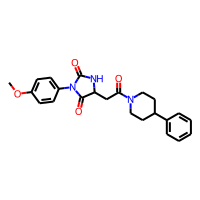
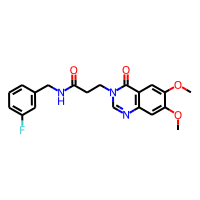

In [65]:
show(EUOS_db.head(2))

In [69]:
EU_OS_mol_descs = []
EU_OS_ECFP6s = []
EU_OS_topols = []
EU_OS_atom_pairs = []

euos_pbar = enlighten.Counter(total=len(EUOS_db.index), desc='Encoding EU-OS bioactives', unit='ticks')

for ID, row in EUOS_db.iterrows():
    mol = row.ROMol
    descriptor = desc_calc.CalcDescriptors(mol)

    ECFP6_vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)
    topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

    EU_OS_mol_descs.append(descriptor)
    EU_OS_ECFP6s.append(ECFP6_vec)
    EU_OS_topols.append(topol_vec)
    EU_OS_atom_pairs.append(atpair_vec)

    euos_pbar.update()



In [73]:
def evaluate(model, input_data):
    pred_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        input_data
    )
    output = model.predict(pred_dataset)

    return output

In [70]:
euos_arr = np.array(EU_OS_mol_descs, dtype=np.float64)

In [71]:
pred_df = pd.DataFrame(euos_arr, columns=desc_calc.descriptorNames)

In [75]:
pred_outcomes = evaluate(gbt_model1, pred_df)

5/5 [==============================] - 1s 68ms/step


In [76]:
EUOS_db['Predictions'] = pred_outcomes

,Supplier,Supplier_ID,ID,ROMol,Predictions
2709,MolPort,MolPort-046-683-507,EOS100246,,0.999279
3257,MolPort,MolPort-046-417-461,EOS100794,,0.999195
2582,MolPort,MolPort-016-633-312,EOS100119,,0.999192
3521,MolPort,MolPort-021-783-237,EOS101058,,0.999149
3715,MolPort,MolPort-042-676-233,EOS101252,,0.999129

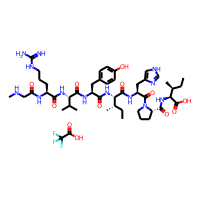
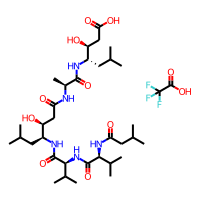
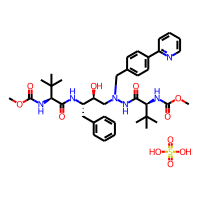
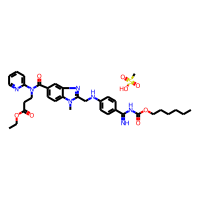
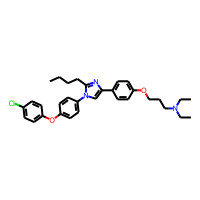

In [79]:
show(EUOS_db.sort_values(by=['Predictions'], ascending=False).head(5))